## Koneksi Dataset dengan Google Drive

In [50]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import Library

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# To Use Algorithm
from keras.layers import Dense, LSTM
import tensorflow as tf

## Memasukan Dataset

In [52]:
df=pd.read_csv('/content/gdrive/My Drive/Startup/DicodingMLPemula/Time_Series/openweatherdata-denpasar-1990-2020.csv')
#df_test=pd.read_csv('/content/gdrive/My Drive/Sanbercode/Week4/Project/test.csv')
#df_test=pd.read_csv('/content/gdrive/My Drive/Sanbercode/Week4/Project/test.csv')
#df_test=pd.read_csv('/content/gdrive/My Drive/Sanbercode/Week4/Project/test.csv')

## Memanggil 10 ribu data terakhir

In [53]:
df.tail(10000)

,dt,dt_iso,timezone,city_name,lat,lon,temp,temp_min,temp_max,pressure,sea_level,grnd_level,humidity,wind_speed,wind_deg,rain_1h,rain_3h,rain_6h,rain_12h,rain_24h,rain_today,snow_1h,snow_3h,snow_6h,snow_12h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
254924,1542708000,2018-11-20 10:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,29.0,29.0,29.0,1009.0,NaN,NaN,79,4.12,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02d
254925,1542711600,2018-11-20 11:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1010.0,NaN,NaN,84,3.60,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
254926,1542715200,2018-11-20 12:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1010.0,NaN,NaN,84,4.12,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
254927,1542718800,2018-11-20 13:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1011.0,NaN,NaN,84,2.57,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
254928,1542722400,2018-11-20 14:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1011.0,NaN,NaN,84,4.12,260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,1578423600,2020-01-07 19:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,NaN,NaN,94,4.10,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264920,1578427200,2020-01-07 20:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,27.0,27.0,27.0,1007.0,NaN,NaN,94,5.70,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264921,1578430800,2020-01-07 21:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,NaN,NaN,83,6.70,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
264922,1578434400,2020-01-07 22:00:00 +0000 UTC,28800,Denpasar,-8.652497,115.219117,28.0,28.0,28.0,1007.0,NaN,NaN,83,6.20,290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n


## Mengklasifikasikan Cuaca

Clouds          220657
Rain             34901
Thunderstorm      4724
Clear             3941
Haze               548
Mist                74
Smoke               29
Fog                 16
Dust                10
Tornado              8
Drizzle              8
Ash                  4
Squall               4
Name: weather_main, dtype: int64


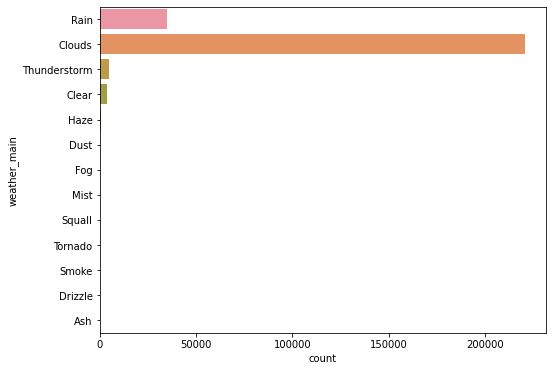

In [54]:
print(df['weather_main'].value_counts())
plt.figure(1, figsize=(8, 6))
sns.countplot(y='weather_main', data=df)
plt.show()

## Mengecek Missing Value Pada Data dan memilah Data yang akan digunakan
dan melakukan Drop Kolom dengan missing value besar

In [55]:
df.isnull().sum()

dt                          0
dt_iso                      0
timezone                    0
city_name                   0
lat                         0
lon                         0
temp                        0
temp_min                    0
temp_max                    0
pressure                    0
sea_level              264924
grnd_level             264924
humidity                    0
wind_speed                  0
wind_deg                    0
rain_1h                248638
rain_3h                248768
rain_6h                228826
rain_12h               264912
rain_24h               258107
rain_today             264924
snow_1h                264924
snow_3h                264924
snow_6h                264924
snow_12h               264924
snow_24h               264924
snow_today             264924
clouds_all                  0
weather_id                  0
weather_main                0
weather_description         0
weather_icon                0
dtype: int64

In [56]:
df.drop(columns=['sea_level', 'grnd_level', 'rain_1h', 'rain_3h','rain_6h',
                 'snow_today','rain_today','rain_12h','rain_24h',
                 'snow_1h','snow_3h','snow_6h','snow_12h','snow_24h'],
                 inplace=True, axis=1)

In [57]:
df.isnull().sum()

dt                     0
dt_iso                 0
timezone               0
city_name              0
lat                    0
lon                    0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [58]:
df.drop(columns=['lat', 'lon', 'timezone',],
                 inplace=True, axis=1)

In [59]:
df.drop(columns=['dt','weather_icon'],
                 inplace=True, axis=1)

In [60]:
df

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description
0,1990-01-01 00:00:00 +0000 UTC,Denpasar,25.82,25.82,25.82,1010.0,86,1.36,225,98,500,Rain,light rain
1,1990-01-01 01:00:00 +0000 UTC,Denpasar,26.20,26.20,26.20,1011.0,84,2.09,247,91,500,Rain,light rain
2,1990-01-01 02:00:00 +0000 UTC,Denpasar,26.45,26.45,26.45,1011.0,84,2.44,262,94,500,Rain,light rain
3,1990-01-01 03:00:00 +0000 UTC,Denpasar,26.80,26.80,26.80,1011.0,82,2.29,271,94,500,Rain,light rain
4,1990-01-01 04:00:00 +0000 UTC,Denpasar,27.04,27.04,27.04,1010.0,82,1.71,274,76,803,Clouds,broken clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264919,2020-01-07 19:00:00 +0000 UTC,Denpasar,27.00,27.00,27.00,1007.0,94,4.10,300,75,803,Clouds,broken clouds
264920,2020-01-07 20:00:00 +0000 UTC,Denpasar,27.00,27.00,27.00,1007.0,94,5.70,300,75,803,Clouds,broken clouds
264921,2020-01-07 21:00:00 +0000 UTC,Denpasar,28.00,28.00,28.00,1007.0,83,6.70,290,75,803,Clouds,broken clouds
264922,2020-01-07 22:00:00 +0000 UTC,Denpasar,28.00,28.00,28.00,1007.0,83,6.20,290,40,802,Clouds,scattered clouds


In [61]:
df.drop(columns=['city_name'],
                 inplace=True, axis=1)

## Membagi data yang akan dijadikan latih dan validasi sebesar 80:20

In [62]:
df_latih = df[254923:262923] #Mengambil data latih 8 Ribu
df_validasi = df[262924:264925] #Mengambil data validasi 2 Ribu

## Membuat Grafik Waktu dan Temperatur

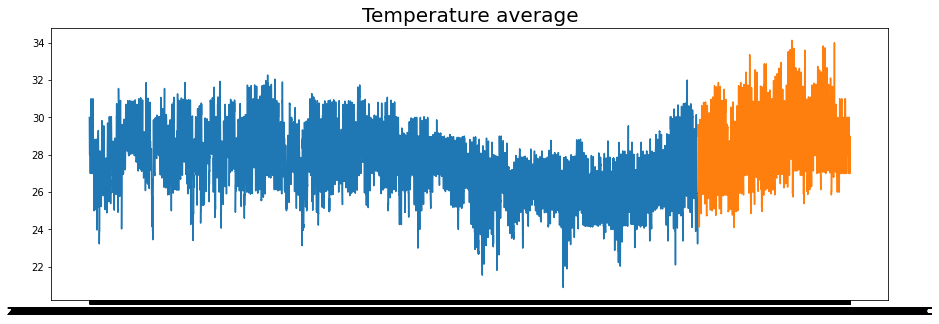

In [63]:
dates_latih = df_latih['dt_iso']
temp_train  = df_latih['temp'].values

dates_valid = df_validasi['dt_iso'].values
temp_valid = df_validasi['temp'].values

 
plt.figure(figsize=(15,5))
plt.plot(dates_latih, temp_train)
plt.title('Temperature average',
          fontsize=20);
plt.plot(dates_valid, temp_valid)
plt.title('Temperature average',
          fontsize=20);

In [77]:
train_temp=temp_train.reshape(-1, 1)
valid_temp=temp_valid.reshape(-1, 1)

In [82]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
temp_train_new=scaler.fit_transform(train_temp)
temp_valid_new=scaler.fit_transform(valid_temp)

In [89]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

## Membuat Arsitektur Tensorflow LSTM 

In [93]:
test_set = windowed_dataset(temp_train_new, window_size=60, batch_size=32, shuffle_buffer=1000)
train_set = windowed_dataset(temp_valid_new, window_size=60, batch_size=32, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
  tf.keras.layers.LSTM(128, dropout=0.1, recurrent_dropout=0.1, return_sequences=True),
  tf.keras.layers.LSTM(64, dropout=0.1, recurrent_dropout=0.1),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [96]:
optimizer = tf.keras.optimizers.Adam()
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## Training Data

In [97]:
history = model.fit(train_set,epochs=10 , callbacks=[reduce_lr], validation_data=(test_set))

Epoch 1/10
61/61 [==============================] - 53s 749ms/step - loss: 0.0199 - mae: 0.1606 - val_loss: 0.0151 - val_mae: 0.1457
Epoch 2/10
61/61 [==============================] - 36s 586ms/step - loss: 0.0063 - mae: 0.0884 - val_loss: 0.0043 - val_mae: 0.0738
Epoch 3/10
61/61 [==============================] - 36s 586ms/step - loss: 0.0058 - mae: 0.0843 - val_loss: 0.0042 - val_mae: 0.0732
Epoch 4/10
61/61 [==============================] - 36s 588ms/step - loss: 0.0050 - mae: 0.0763 - val_loss: 0.0064 - val_mae: 0.0929
Epoch 5/10
61/61 [==============================] - 36s 590ms/step - loss: 0.0048 - mae: 0.0754 - val_loss: 0.0034 - val_mae: 0.0645
Epoch 6/10
61/61 [==============================] - 36s 590ms/step - loss: 0.0045 - mae: 0.0731 - val_loss: 0.0051 - val_mae: 0.0790
Epoch 7/10
61/61 [==============================] - 36s 587ms/step - loss: 0.0047 - mae: 0.0750 - val_loss: 0.0051 - val_mae: 0.0822
Epoch 8/10
61/61 [==============================] - 36s 585ms/step - 

## Plot loss dan akurasi pada saat training dan validation

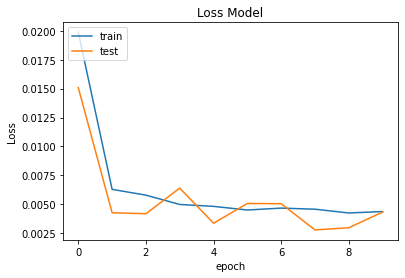

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

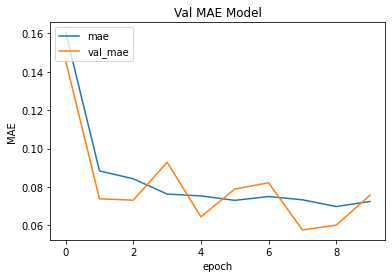

In [101]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Val MAE Model')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['mae', 'val_mae'], loc = 'upper left')
plt.show()